In [140]:
import sys
sys.path.append("src")

import importlib
importlib.reload(cnn_autoenc)
import cnn_autoenc as ca

In [16]:
CONFIG_FILE = "C:/Users/Matt/Documents/nbs/autoenc/configs/mnist.json"
RAW_DATA_DIR = "J:/Datasets/Planet/Salinas_001/20171028_190652_1056020_RapidEye-5"
RAW_DATA_FILE = "1056020_2017-10-28_RE5_3A_Visual.tif"


In [5]:
import csv
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import scipy
import sklearn
import shutil
import tensorflow as tf

from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
from sklearn import mixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_samples

pj = os.path.join

%matplotlib inline

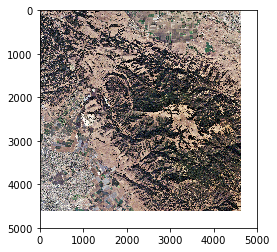

In [17]:
salinas1 = pj(RAW_DATA_DIR, RAW_DATA_FILE)
im = plt.imread(salinas1)
plt.imshow(im)

In [62]:
g_chip_size = 50
g_num_chans = 3

9801


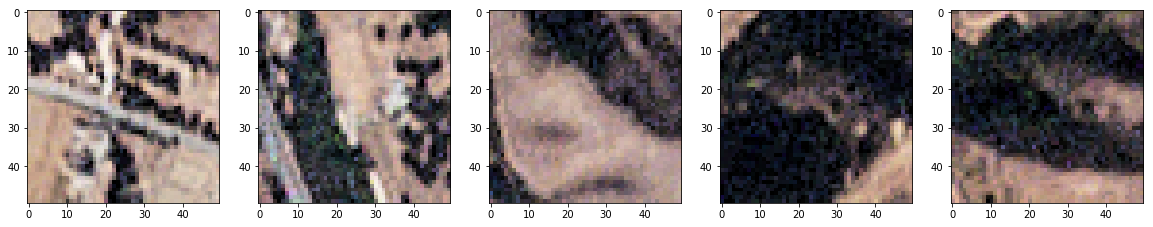

In [69]:
def create_chips(large_image):
    M = large_image.shape[0]
    N = large_image.shape[1]
    i = 0
    chips = []
    while i < M - g_chip_size:
        j = 0
        while j < N - g_chip_size:
            chip = large_image[i:i+g_chip_size, j:j+g_chip_size, 0:g_num_chans]
            chips.append(chip)
            j += g_chip_size
        i += g_chip_size
    return chips

chips = create_chips(im)
print(len(chips))
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i,ax in enumerate(axes):
    ax.imshow(chips[i*1000])

In [124]:
conf = {}
conf["batch_size"] = 64
conf["fc_bottleneck"] = False

conf["regularize"] = False
conf["num_epochs"] = 10
conf["lambda"] = 0.1
conf["lr"] = 0.001
conf["momentum"] = 0.9

In [125]:
conf["numh"] = 8
conf["num_filts1"] = 128
conf["num_filts2"] = 64
conf["num_filts3"] = 32
conf["stride"] = 2
conf["pool_size"] = 2

#The size of the filters, *not* the size of the convolution kernel
conf["filt_size1"] = 3
conf["filt_size2"] = 3
conf["filt_size3"] = 3

conf["upsamp_sz1"] = 7
conf["upsamp_sz2"] = 14
conf["upsamp_sz3"] = g_chip_size

print("Number of samples: " + str(g_chip_size))
print("Filt size 1: " + str(conf["filt_size1"]))
print("Filt size 2: " + str(conf["filt_size2"]))
print("Filt size 3: " + str(conf["filt_size3"]))

Number of samples: 50
Filt size 1: 3
Filt size 2: 3
Filt size 3: 3


In [126]:
tf.reset_default_graph()

In [127]:
x = tf.placeholder(tf.float32, shape=(None, g_chip_size, g_chip_size, g_num_chans), name="x")

In [128]:
def make_conv_layer(t_in, filt_sz, stride, pool_sz, num_filts, name):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        filt_shape = [filt_sz, filt_sz, int(t_in.shape[3]), num_filts]
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())
        #tf.layers.conv2d uses the glorot_uniform_initializer
        
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
        y = tf.nn.conv2d(t_in,
                         W,
                         [1, 1, 1, 1],
                         padding="SAME") + b
        mp = tf.layers.max_pooling2d(y,
                                    pool_sz,
                                    strides=stride,
                                    padding="SAME",
                                    name=name+"_mp")
        act = tf.nn.relu(mp, name=name+"_relu")

        tf.summary.histogram(act.name, act)
        print("act: ", act.shape)
        
        return act   

In [129]:
def make_deconv_layer(t_in, upsamp_sz, num_filts, name, use_relu=True):
    assert(len(t_in.shape)==4)
    with tf.name_scope(name):
        upsample = tf.image.resize_nearest_neighbor(t_in, (upsamp_sz, upsamp_sz))
        
        filt_shape = [int(t_in.shape[1]), int(t_in.shape[2]), int(t_in.shape[3]), num_filts]
        W = tf.get_variable(name+"_W", filt_shape, initializer=tf.contrib.layers.xavier_initializer())        
        b = tf.get_variable(name+"_b", [num_filts], initializer=tf.zeros_initializer())
    
        deconv = tf.nn.conv2d(upsample, 
                              W, 
                              [1, 1, 1, 1],
                              "SAME") + b
        print("deconv: ", deconv.shape)

        if use_relu:
            act = tf.nn.relu(deconv, name=name+"_relu")
        else:
            act = deconv
            
        tf.summary.histogram(act.name, act)
        print(act.shape)
        
        return act

In [130]:
def make_fc_layer(t_in, fan_out, name):
    assert(len(t_in.shape)==2)
    with tf.name_scope(name):
        W = tf.Variable(tf.random_normal([int(t_in.shape[1]), fan_out], stddev=1), name=name+"_W")
        b = tf.Variable(tf.random_normal([fan_out], stddev=1), name=name+"_b")
        y = tf.matmul(t_in, W) + b
        act = tf.nn.sigmoid(y, name=name+"_sigmoid")
        tf.summary.histogram(act.name, act)
        return act

In [131]:
conv1 = make_conv_layer(x, conf["filt_size1"], conf["stride"], conf["pool_size"], conf["num_filts1"], "conv1")
conv2 = make_conv_layer(conv1, conf["filt_size2"], conf["stride"], conf["pool_size"], conf["num_filts2"], "conv2")
conv3 = make_conv_layer(conv2, conf["filt_size3"], conf["stride"], conf["pool_size"], conf["num_filts3"], "conv3")

INFO:tensorflow:Summary name conv1/conv1_relu:0 is illegal; using conv1/conv1_relu_0 instead.
act:  (?, 25, 25, 128)
INFO:tensorflow:Summary name conv2/conv2_relu:0 is illegal; using conv2/conv2_relu_0 instead.
act:  (?, 13, 13, 64)
INFO:tensorflow:Summary name conv3/conv3_relu:0 is illegal; using conv3/conv3_relu_0 instead.
act:  (?, 7, 7, 32)


In [132]:
if conf["fc_bottleneck"]:
    fc_start0 = make_conv_layer(conv3, 2, 2, 2, conf["num_filts3"], "fc_start0")
    fc_start = tf.squeeze( make_conv_layer(fc_start0, 2, 2, 2, conf["num_filts3"], "conv_bottle"), [1, 2])

    hc = make_fc_layer(fc_start, conf["numh"], "hc")
    deconv_start0 = make_deconv_layer(tf.reshape(hc,[-1, 1, 1, int(hc.shape[1])]), 2, conf["num_filts3"], "deconv_start0")
    deconv_start = make_deconv_layer(deconv_start0, 2, conf["num_filts3"], "deconv_bottle")
else:
    deconv_start = conv3

In [133]:
target = x

In [134]:
deconv1 = make_deconv_layer(deconv_start, conf["upsamp_sz1"], conf["num_filts3"], "deconv1")
deconv2 = make_deconv_layer(deconv1, conf["upsamp_sz2"], conf["num_filts2"], "deconv2")
deconv3 = make_deconv_layer(deconv2, conf["upsamp_sz3"], conf["num_filts1"], "deconv3")

deconv:  (?, 7, 7, 32)
INFO:tensorflow:Summary name deconv1/deconv1_relu:0 is illegal; using deconv1/deconv1_relu_0 instead.
(?, 7, 7, 32)
deconv:  (?, 14, 14, 64)
INFO:tensorflow:Summary name deconv2/deconv2_relu:0 is illegal; using deconv2/deconv2_relu_0 instead.
(?, 14, 14, 64)
deconv:  (?, 50, 50, 128)
INFO:tensorflow:Summary name deconv3/deconv3_relu:0 is illegal; using deconv3/deconv3_relu_0 instead.
(?, 50, 50, 128)


In [135]:
out = tf.layers.conv2d(deconv3, 
                       g_num_chans, 
                       (conf["filt_size1"], conf["filt_size1"]),
                       padding='same',
                       activation=None)
print("out: ", out.shape)

decoded = tf.nn.sigmoid(out, name='decoded')

out:  (?, 50, 50, 4)


In [136]:
with tf.name_scope("conv_mse"):
    sq_error = tf.reduce_mean(np.square(out - target), axis=1)
    cost = tf.reduce_mean( sq_error, name="cost" )
    accuracy = None

    tf.summary.scalar("cost", cost)
    tf.summary.scalar("accuracy", accuracy)

        
with tf.name_scope("conv_opt"):
    optimizer = tf.train.AdamOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.RMSPropOptimizer(learning_rate=conf["lr"])
#    optimizer = tf.train.MomentumOptimizer(learning_rate=conf["lr"], momentum=conf["momentum"])
#    optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf["lr"])
    training_op = optimizer.minimize(cost)

ValueError: Tried to convert 'values' to a tensor and failed. Error: None values not supported.